# Нейронная сеть для распознования эмоций по голосу

In [ ]:
!pip install git+https://github.com/librosa/librosa  # Установка librosa (для использованя функции librosa.features.inverse.mfcc_to_audio)

  Cloning https://github.com/librosa/librosa to /tmp/pip-req-build-zn733hwe
  Running command git clone -q https://github.com/librosa/librosa /tmp/pip-req-build-zn733hwe
     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201377 sha256=3811f06fa7c6f68d90c7556e2736d48f898b1057672b23a4dbb734bc8da4f526
  Stored in directory: /tmp/pip-ephem-wheel-cache-a62h4tid/wheels/ff/3e/4c/a872019d317d55de16e91a60bee1fb10a6404d1edb91fb4318
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np # библиотека для работы с массивами данных
from matplotlib import pyplot as plt # интерфейс для построения графиков простых функций
from IPython.display import Audio # загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from google.colab import files # модуль для загрузки файлов
import librosa # для параметризации аудио
import os # модуль для работы с операционной системой(воспользуемся методами работы с каталогами)
from sklearn.model_selection import train_test_split # модуль для разбивки данных на обучающую и тестовую выборки
from keras.utils import to_categorical # загружаем утилиты кераса для one hot кодировки
from tqdm import tqdm # быстрый, удобный progress bar для Python
from keras.optimizers import Adam, RMSprop, Adadelta # загружаем алгоритмы обучения/оптимизации
from keras.models import Sequential # последовательная модель нейросети кераса
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, CuDNNLSTM, Reshape # загружаем необходимые слои для нейросети
import IPython.display as ipd # Воспроизведение звуковыйх файлов

Using TensorFlow backend.


In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/Emotion/'

EmotionOAF  EmotionYAF	model_speech.h5


In [ ]:
# Зададим параметры данных, к-е пойдут на вход нейросети
DATA_PATH = "/content/drive/My Drive/Emotion/EmotionYAF/" # зададим путь к папке с аудиофайлами
DATA_PATH_TEST = "/content/drive/My Drive/Emotion/EmotionOAF/" # Зададим пусть к файлу с тестовыми 30секнудными аудиофайлами

sample_rate = 22050 # Значение sample_rate аудиофайлов
feature_dim_1 = 20 # стандартная величина MFCC признаков
feature_dim_2 = int(.5 * sample_rate) # установленная длина фреймов (в секундах 0.5 =  500 мс)
step_mfcc = int(.02 * sample_rate) # Шаг смещения при разборе mfcc (в секундах 0.1 = 100мс)
channel = 1 # количество каналов
n_classes = 7 # Количество классов команд
classes = ['гнев', 'отвращение', 'страх', 'счастье', 'приятный сюрприз', 'грусть', 'нейтраный'] # Классы команд (без фона)
#classes = ['YAF_angry', 'YAF_disgust', 'YAF_Fear', 'YAF_happy', 'YAF_Pleasant_surprise', 'YAF_Sad', 'YAF_neutral'] # Классы команд (без фона)

In [ ]:
'''
Зададим функцию извлечения лейблов классов и их обработки
  Параметры:
    path - путь к папке, в которой находятся каталоги с обучающими командами    
'''

def get_labels(path=DATA_PATH): 
  labels = sorted(os.listdir(path)) # запишем лейблы классов по названию папок с данными - ['гнев', 'отвращение', 'страх', 'счастье', 'приятный сюрприз', 'грусть', 'нейтраный']  
  label_indices = np.arange(0, len(labels)) # запишем лейблы в виде индексов - [0, 1, 2, 3, 4, 5, 6]
  return labels, label_indices, to_categorical(label_indices) # функция вернёт лейблы, индексы лейблов и их one-hot представление[0, 1, 0, 0, 0, 0, 0]

In [ ]:
im = np.random.randint(0, 6, (7,7))

In [ ]:
im

array([[0, 3, 3, 5, 0, 0, 1],
       [3, 2, 3, 3, 2, 4, 2],
       [1, 0, 3, 1, 4, 5, 2],
       [2, 5, 1, 5, 2, 1, 4],
       [3, 2, 3, 4, 3, 3, 4],
       [0, 0, 1, 2, 4, 4, 1],
       [3, 1, 2, 5, 2, 3, 2]])

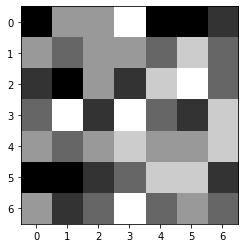

In [ ]:
plt.imshow(im, cmap='gray')

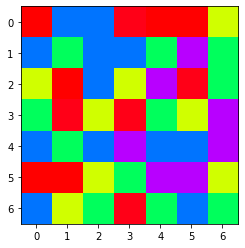

In [ ]:
plt.imshow(im, cmap='hsv')

In [ ]:
'''
Создаем функцию параметризации аудио(wav в мел-частоты)
  Параметры:
    length - длинна отрезков, на которые разбиваем исходный файл
    step - шаг, на который смещаем разбиение отрезка
'''

def wav2mfcc(file_path, length = 11025, step = 2205): 
  out_mfcc = [] # Выходной массив, содержащий mfcc исходного файла с шагом step
  out_audio = [] # Выходной массив, содеражищий аудиоинформацию исходного файла с шагом step
  y, sr = librosa.load(file_path) # Загружаем данные исходного файла  

  while (len(y)>=length):  # Проходим весь массив y, пока оставшийся кусочек не станет меньше указанной в параметре max_len длинны
    section = y[:length] # Берем начальный кусок длинной length
    section = np.array(section) # Переводим в numpy
    out_mfcc.append(librosa.feature.mfcc(section, sr)) # Добавляем в выходной массив out_mfcc значение mfcc текущего куска
    out_audio.append(section) # Добавляем в выходной массив аудио текущий кусок
    y = y[step:]  # Уменьшаем y на step
    
  out_mfcc = np.array(out_mfcc) # Преобразуем в numpy
  out_audio = np.array (out_audio) # Преобразуем в numpy
  return out_mfcc, out_audio # функция вернет массив мэл-частот и массив аудио-отрезков

In [ ]:
'''
Объявим функцию формирования и сохранения векторов данных, полученных для каждого набора аудио-команд в датасете
  Параметры:
    path  - путь к папке, в которой находятся каталоги с обучающими командами    
    length - длинна отрезков, на которые разбиваем исходный файл
'''

def save_data_to_array(path=DATA_PATH, length=11025):
  labels, _, _ = get_labels(path) # запишем лейблы классов
  for label in labels: # для каждого лейбла
    mfcc_vectors = [] # здесь соберем векторы MFCC частот
    # извлечем для каждого файла его путь c названием папки и именем файла и соберём в список
    
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)): # для каждого файла
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc) # получим мел-частоты      
      if (mfcc.shape[0] != 0 ): # Если массив не нулевой длинны
        mfcc_vectors.extend(mfcc) # и добавим вектор в список для соответствующего класса
    np.save(label + '.npy', mfcc_vectors) # сохраним массивы данных для каждого класса

In [ ]:
'''
Создадим функцию для получения обучающей/проверочной выборки
  Параметры (необязательные):
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split
    random_state - начальное число, используемое генератором случайных чисел в финкции train_test_split
'''

def get_train_test(split_ratio=0.7, random_state=42, colab = True):
  labels, indices, _ = get_labels(DATA_PATH) # извлекаем имена и индексы лейблов классов

  # Getting first arrays
  X = np.load(labels[0] + '.npy') # берем набор векторов для первого класса 
  y = np.zeros(X.shape[0], dtype = 'int32') # устанавливаем размер соответствующего ему лейбла

  # Объединяем в единый датасет в виде np-массива обучающий и проверочный набор данных
  for i, label in enumerate(labels[1:]): 
    x = np.load(label + '.npy') # Читаем очередной массив данных 
    X = np.vstack((X, x)) # Соединяем с исходным набором
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1))) # В массив y добавлем x.shape[0]-элеменентов со значением (i + 1)

  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) # Разделяем данные на обучающую и проверочную выборки

In [ ]:
# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете
save_data_to_array(length=feature_dim_2)

Сохраняем векторы класса - 'YAF_neutral': 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]
Сохраняем векторы класса - 'YAF_pleasant_surprised': 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
Сохраняем векторы класса - 'YAF_sad': 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


In [ ]:
##########################
# Формируем обучающую и проверочную выборки
##########################
x_train, x_test, y_train, y_test = get_train_test(colab=False) # создаем обучающий/проверочный наборы
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(78427, 20, 22) (78427,)
(33612, 20, 22) (33612,)


In [ ]:
# Добавляем значение канала(=1) в размеры 'x' выборок
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], channel)
x_train = x_train[..., None]
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], channel)
x_test = x_test[..., None]

y_train_hot = to_categorical(y_train) # представляем лейблы классов обучающего набора в виде one-hot вектора ((0, 1, 0) и т.п)
y_test_hot = to_categorical(y_test) # представляем лейблы классов проверочного набора в виде one-hot вектора ((0, 1, 0) и т.п)

In [ ]:
x_train.shape

(78427, 20, 22, 1)

In [ ]:
idx = np.where(y_train==6)
idx[0].shape

(12579,)

# Нейросеть

In [ ]:
##########################
# Объявим функцию создания модели нейросети
##########################
def get_model():
  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(BatchNormalization()) # пропускаем через слой нормализации данных
  model.add(Flatten()) # сплющиваем в одномерный вектор  
  model.add(Dense(128, activation='relu')) # добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization()) # пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # добавляем полносвязный слой с функцией активации softmax на выходном слое для 3 классов
  model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy']) # компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  return model

In [ ]:
model = get_model() # создаем модель с помощью объявленной ранее функции

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005, beta_1=0.03),
              metrics=['accuracy'])
idx0 = np.where(y_train==0)[0]
idx1 = np.where(y_train==1)[0]
idx2 = np.where(y_train==2)[0]
idx3 = np.where(y_train==3)[0]
idx4 = np.where(y_train==4)[0]
idx5 = np.where(y_train==5)[0]
idx6 = np.where(y_train==6)[0]


batch_size = 121
for i in range(200):
  batch_0 = np.random.choice(idx0, batch_size//6, replace=False)
  batch_1 = np.random.choice(idx1, batch_size//6, replace=False)
  batch_2 = np.random.choice(idx2, batch_size//6, replace=False)
  batch_3 = np.random.choice(idx3, batch_size//6, replace=False)
  batch_4 = np.random.choice(idx4, batch_size//6, replace=False)
  batch_5 = np.random.choice(idx5, batch_size//6, replace=False)
  batch_6 = np.random.choice(idx6, batch_size//6, replace=False)
  
  x_0 = x_train[batch_0]
  x_1 = x_train[batch_1]
  x_2 = x_train[batch_2]
  x_3 = x_train[batch_3]
  x_4 = x_train[batch_4]
  x_5 = x_train[batch_5]
  x_6 = x_train[batch_6]
   
  y_0 = y_train_hot[batch_0]
  y_1 = y_train_hot[batch_1]
  y_2 = y_train_hot[batch_2]
  y_3 = y_train_hot[batch_3]
  y_4 = y_train_hot[batch_4]
  y_5 = y_train_hot[batch_5]
  y_6 = y_train_hot[batch_6]
   
  x = np.concatenate([x_0, x_1, x_2, x_3, x_4, x_5, x_6], axis = 0)
  y = np.concatenate([y_0, y_1, y_2, y_3, y_4, y_5, y_6], axis = 0)

  shuffle_idx = np.random.choice(batch_size, batch_size, replace=False)


  
  loss, acc = model.train_on_batch(x[shuffle_idx], y[shuffle_idx])
  print ('loss:', loss, '- acc:', acc)


loss: 2.5664098 - acc: 0.12396694
loss: 2.4597456 - acc: 0.16528925
loss: 2.544698 - acc: 0.1322314
loss: 2.2421434 - acc: 0.14876033
loss: 2.1922774 - acc: 0.2231405
loss: 2.0585158 - acc: 0.23966943
loss: 1.8163851 - acc: 0.36363637
loss: 1.894896 - acc: 0.29752067
loss: 1.875205 - acc: 0.2892562
loss: 1.8827114 - acc: 0.3140496
loss: 1.7808001 - acc: 0.38016528
loss: 1.7454338 - acc: 0.38842976
loss: 1.6368915 - acc: 0.38842976
loss: 1.6576229 - acc: 0.42975205
loss: 1.6059964 - acc: 0.3966942
loss: 1.6291143 - acc: 0.38842976
loss: 1.3805147 - acc: 0.47107437
loss: 1.3619256 - acc: 0.4876033
loss: 1.3899748 - acc: 0.49586776
loss: 1.4107109 - acc: 0.5041322
loss: 1.2953478 - acc: 0.5289256
loss: 1.2914491 - acc: 0.5785124
loss: 1.3321213 - acc: 0.5041322
loss: 1.3788165 - acc: 0.5289256
loss: 1.3539196 - acc: 0.5206612
loss: 1.2838401 - acc: 0.57024795
loss: 1.2131033 - acc: 0.57024795
loss: 1.0683838 - acc: 0.6859504
loss: 1.1444039 - acc: 0.59504133
loss: 1.2233528 - acc: 0.5867

In [ ]:
idx0[0]

7

In [ ]:
model.save_weights('/content/drive/My Drive/Emotion/model_speech.h5')

Train on 78427 samples, validate on 33612 samples
Epoch 1/100
78427/78427 [==============================] - 2s 28us/step - loss: 0.0111 - accuracy: 0.9968 - val_loss: 0.0255 - val_accuracy: 0.9916
Epoch 2/100
78427/78427 [==============================] - 2s 26us/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0065 - val_accuracy: 0.9979
Epoch 3/100
78427/78427 [==============================] - 2s 27us/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0052 - val_accuracy: 0.9984
Epoch 4/100
78427/78427 [==============================] - 2s 27us/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0074 - val_accuracy: 0.9975
Epoch 5/100
78427/78427 [==============================] - 2s 27us/step - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.0073 - val_accuracy: 0.9976
Epoch 6/100
78427/78427 [==============================] - 2s 28us/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.0095 - val_accuracy: 0.9968
Epoch 7/100
78427/78427 [==============================] - 2s 

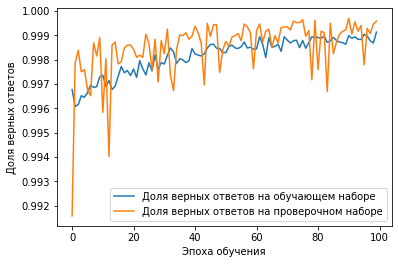

In [ ]:
##########################
# Запустим тренировку нейросети на полученных данных
##########################

# Загружаем модель данными с выбором параметров и сохраним историю обучения(ошибки/точность) для вывода графика
history = model.fit(x_train, y_train_hot, batch_size=256, epochs=100, verbose=1, validation_data=(x_test, y_test_hot))

# Построим график, отображающий точность предсказания на обучающей и проверочной выборке
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model.save_weights('/content/drive/My Drive/Emotion/model_speech.h5')

# Проверка

In [ ]:
wavfiles =  DATA_PATH_TEST + 'OAF_angry/OAF_dead_angry.wav' # Получаем имя очередного файла
y,sr = librosa.load(wavfiles) # Загружаем данные модулем librosa
print ('Оригинальный файл:')
ipd.Audio(data=y, rate = sr) # Выводим оригинальный аудиофайл 

Оригинальный файл:


In [ ]:
mfcc_full, audio_full = wav2mfcc (wavfiles, length=feature_dim_2, step = step_mfcc) # Получаем массив mfcc выбранного файла с именем namefile 

mfcc_full = mfcc_full.reshape(-1, 20, 22, 1) # Решейпим для сверточного слоя
g_pred = model.predict(mfcc_full) # Предиктим с помощью модели model массив mfcc
pred = np.array([np.argmax(i) for i in g_pred]) # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов

g_pred = np.asarray(g_pred)
print (g_pred.shape)
print (pred.shape)
print (pred[:500])

(50, 7)
(50,)
[2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 1 3 3 3]


In [ ]:
idxs = np.where(pred == 3) # В массиве pred находим все элементы со значением, равным искомому классу idx_class
idxs = idxs[0] # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность

print (idxs)

[47 48 49]


In [ ]:
curr = [] # Временный массив для хранения информации о найденных командах
'''
в массиве idx данные могут быть прдеставлены следующим образом:
[4, 5, 6, 7, 123, 124, 125, 126, 127]
в массив curr мы запишем [4, 123] только стартовые индексы
поскольку очевидно, что 4,5,6,7 и 123,124,125,126,127 представляют единую команду
'''
curr_idx =int (idxs[0]) # Текущий стартовый индекс
summ, length = 0, 0 # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера                                                                        
                                                              #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
for i in range(len(idxs)): # Пробегаем по всему массиву idxs
  summ += g_pred[idxs[i]][0] # Считаем сумму вероятности
  length += 1 # Увеличиваем длинну последовательности
  if i == len(idxs)-1: # Если последний элемент последовательности
    if (length >= 2 and summ / length >= 0.0): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                        # summ / length должно быть больше входного параметра rate
      curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
    break        
  if idxs[i+1]-idxs[i]>1: # Если следующий индекс больше текущего на 1 (означает, что следующий элемент относится уже к другой комманде)
    if (length >= 8 and summ / length >= 0.95): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                        # summ / length должно быть больше входного параметра rate
      curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
    curr_idx = int (idxs[i+1]) # Изменяем текущий стартовый индекс
    summ, length = 0, 0 # Обнуляем summ и length
print (curr)

[[47, 3, 1.7826333594446926e-08]]


In [ ]:
np_Audio = []
curr_audio = [] # mfcc отдельной команды
for elem in curr: # Проходим по всему массиву curr
  curr_audio = audio_full[elem[0]]
  if (elem[0] != 0): # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее (чаще всего там будет либо тишина, либо начало команды, которое не разобралось сетью)
    curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))        
  for j in range(1,elem[1]): # Пробегаем цикл от 1 до elem[1] (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
    if (elem[0]+j == len(audio_full)): # Если elem[0] + j равно длинне mfcc, то выходим из цикла
      break    
    curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
  curr_audio = np.array(curr_audio) # Переводим массив в numpy
  np_Audio.append([curr_audio, elem[2]]) # Добавляем данные в выходной массив

print (len(curr_audio))


12348


In [ ]:
if (len(np_Audio)==0): # Если длина массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
for elem in np_Audio: # Пробегам по всем элементам массива out
    print ('Распознана команда: "', classes[0], '" (вероятность - %.2f' % (elem[1]*100), '%)') # Выводим название
    ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " гнев " (вероятность - 0.00 %)


In [ ]:
##########################
# Объявим функцию предсказания команды
##########################
def predict(namefile, model, min_count = 2, rate = 0.9, hole = 1): # функция принимает на вход путь к нужному файлу, и имя обученной модели 
  mfcc_full, audio_full = wav2mfcc (namefile, length=feature_dim_2, step = step_mfcc) # Получаем массив mfcc выбранного файла с именем namefile    

  #mfcc = xScaler.transform(mfcc_full.reshape(-1,1))
  mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)
  g_pred = model.predict(mfcc_full) # Предиктим с помощью модели model массив mfcc
  pred = np.array([np.argmax(i) for i in g_pred]) # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов

  out = [] # Объявляем выходную переменную out (В ней будут храниться преобразованные из mfcc ауидоданные, класс команды и точность, с которой сеть считает эту команду верной)  
  # Ищем команды каждого класса
  for idx_class in range(n_classes-1):
    idxs = np.where(pred == idx_class) # В массиве pred находим все элементы со значением, равным искомому классу idx_class
    idxs = idxs[0] # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность
    if (len(idxs) == 0): # Если элементы искомого класса не найдены,
      continue # то переходим к поиску команд следующего класса

    curr = [] # Временный массив для хранения информации о найденных командах
    '''
    в массиве idx данные прдеставлены следующим образом:
    [4, 5, 6, 7, 123, 124, 125, 126, 127]
    в массив curr мы запишем [4, 123] только стартовые индексы
    поскольку очевидно, что 4,5,6,7 и 123,124,125,126,127 представляют единую команду
    '''
    curr_idx =int(idxs[0]) # Текущий стартовый индекс
    summ, length = 0, 0 # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера                                                                        
                                                                  #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
    for i in range(len(idxs)): # Пробегаем по всему массиву idxs
      summ += g_pred[idxs[i]][idx_class] # Считаем сумму вероятности
      length += 1 # Увеличиваем длинну последовательности
      if i == len(idxs)-1: # Если последний элемент последовательности
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length

        break  
      if idxs[i+1]-idxs[i]>hole: # Если следующий индекс больше текущего на hole (означает, что следующий элемент относится уже к другой комманде)
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          print(length)
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
        curr_idx = int (idxs[i+1]) # Изменяем текущий стартовый индекс
        summ, length = 0, 0 # Обнуляем summ и length
    curr_audio = [] # mfcc отдельной команды
    for elem in curr: # Проходим по всему массиву curr
      #if (elem[0] != 0): # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее (чаще всего там будет либо тишина, либо начало команды, которое не разобралось сетью)
      #  curr_audio = np.concatenate((audio_full[elem[0] - 1], audio_full[elem[0]][:, -step_mfcc:,:]), axis = 0)
      #else:
      curr_audio = audio_full[elem[0]] # Если это стартовый элемент исходных данных, то берем самую первую mfcc
      for j in range(1,elem[1]): # Пробегаем цикл от 1 до elem[1]+1 (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
        if (elem[0]+j == len(audio_full)): # Если elem[0] + j равно длинне mfcc, то выходим из цикла
          break
        #curr_audio = np.concatenate((curr_audio, audio_full[elem[0] + j][:,-step_mfcc:,:]), axis = 1) # Создаем единий mfcc, использую concatenate для добавления к текущему значению срез динной step_mfcc из следующего элемента
        curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
      curr_audio = np.array(curr_audio) # Переводим массив в numpy
      #curr_mfcc = curr_mfcc.reshape (curr_mfcc.shape[0], curr_mfcc.shape[1]) # Убираем третью размерность
      #curr_mfcc_unscaled= xScaler.inverse_transform(curr_mfcc)
      #recon = librosa.feature.inverse.mfcc_to_audio(curr_mfcc_unscaled) # Получаем ауди из mfcc
      out.append([curr_audio, idx_class, elem[2]]) # Добавляем данные в выходной массив
  return out, pred, g_pred # Возращаем массив с данными, массив с классами команд, массив с softmax данными

In [ ]:
wavfiles =  DATA_PATH_TEST + 'OAF_angry/OAF_keep_angry.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.0, hole = 2)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[0], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))


Распознана команда: " гнев " (вероятность - 99.28 %)


Распознана команда: " гнев " (вероятность - 98.55 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'OAF_disgust/OAF_back_disgust.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[1], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: " отвращение " (вероятность - 99.60 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'OAF_Fear/OAF_home_fear.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[2], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

13
20
Распознана команда: " страх " (вероятность - 96.39 %)


Распознана команда: " страх " (вероятность - 97.25 %)


Распознана команда: " страх " (вероятность - 99.45 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'OAF_happy/OAF_mode_happy.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[3], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

12
Распознана команда: " счастье " (вероятность - 98.52 %)


Распознана команда: " счастье " (вероятность - 98.56 %)


Распознана команда: " счастье " (вероятность - 99.80 %)


In [107]:
wavfiles =  DATA_PATH_TEST + 'OAF_Pleasant_surprise/OAF_chair_ps.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[4], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

41
6
Распознана команда: " приятный сюрприз " (вероятность - 96.09 %)


Распознана команда: " приятный сюрприз " (вероятность - 97.87 %)


Распознана команда: " приятный сюрприз " (вероятность - 99.72 %)


In [121]:
wavfiles =  DATA_PATH_TEST + 'OAF_Sad/OAF_long_sad.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[5], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

24
44
Распознана команда: " грусть " (вероятность - 99.70 %)


Распознана команда: " грусть " (вероятность - 98.13 %)


In [123]:
wavfiles =  DATA_PATH_TEST + 'OAF_neutral/OAF_dog_neutral.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[6], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

32
14
10
Распознана команда: " нейтраный " (вероятность - 97.21 %)


Распознана команда: " нейтраный " (вероятность - 95.92 %)


Распознана команда: " нейтраный " (вероятность - 92.81 %)
